In [3]:
import sys
sys.path.append("../../") # go to project root dir
from pytracking.evaluation import Tracker

## Create the mask tracker

In [26]:
tracker_name = "rts"
tracker_param = "rts50"
video_path = "/home/asl-student-mf/datasets/baking-in-the-feature/scenes/doughnut1/doughnut1.mp4"
dataset_root = "/home/asl-student-mf/datasets/baking-in-the-feature"
sequences = ["doughnut1"]
mask_path = ""
save_results = True
debug = 0

tracker = Tracker(tracker_name, tracker_param)

In [2]:
from ltr.dataset.vos_base import VOSDatasetBase, VOSMeta
from ltr.data.image_loader import jpeg4py_loader
from pathlib import Path

class BakingInTheFeature(VOSDatasetBase):
    def __init__(self, root, sequences=None, image_loader=jpeg4py_loader):
        super().__init__(name="BakingInTheFeature", root=Path(root), split="train", 
                         multiobj=False, vis_threshold=10, image_loader=image_loader)
        dset_path = self.root
        if sequences:
            sequences = [Path(s) / "rgb" for s in sequences]
        else:
            sequences = [p / "rgb" for p in sorted(dset_path.glob("*")) if p.is_dir()]
        
        self.gmeta = VOSMeta.generate("BakingInTheFeature", )
        
        print("%s loaded." % self.get_name())
    
    
datset =  BakingInTheFeature(os.path.abspath(dataset_root), sequences)

ModuleNotFoundError: No module named 'ltr'

## Read the polygon mask and write it to .png

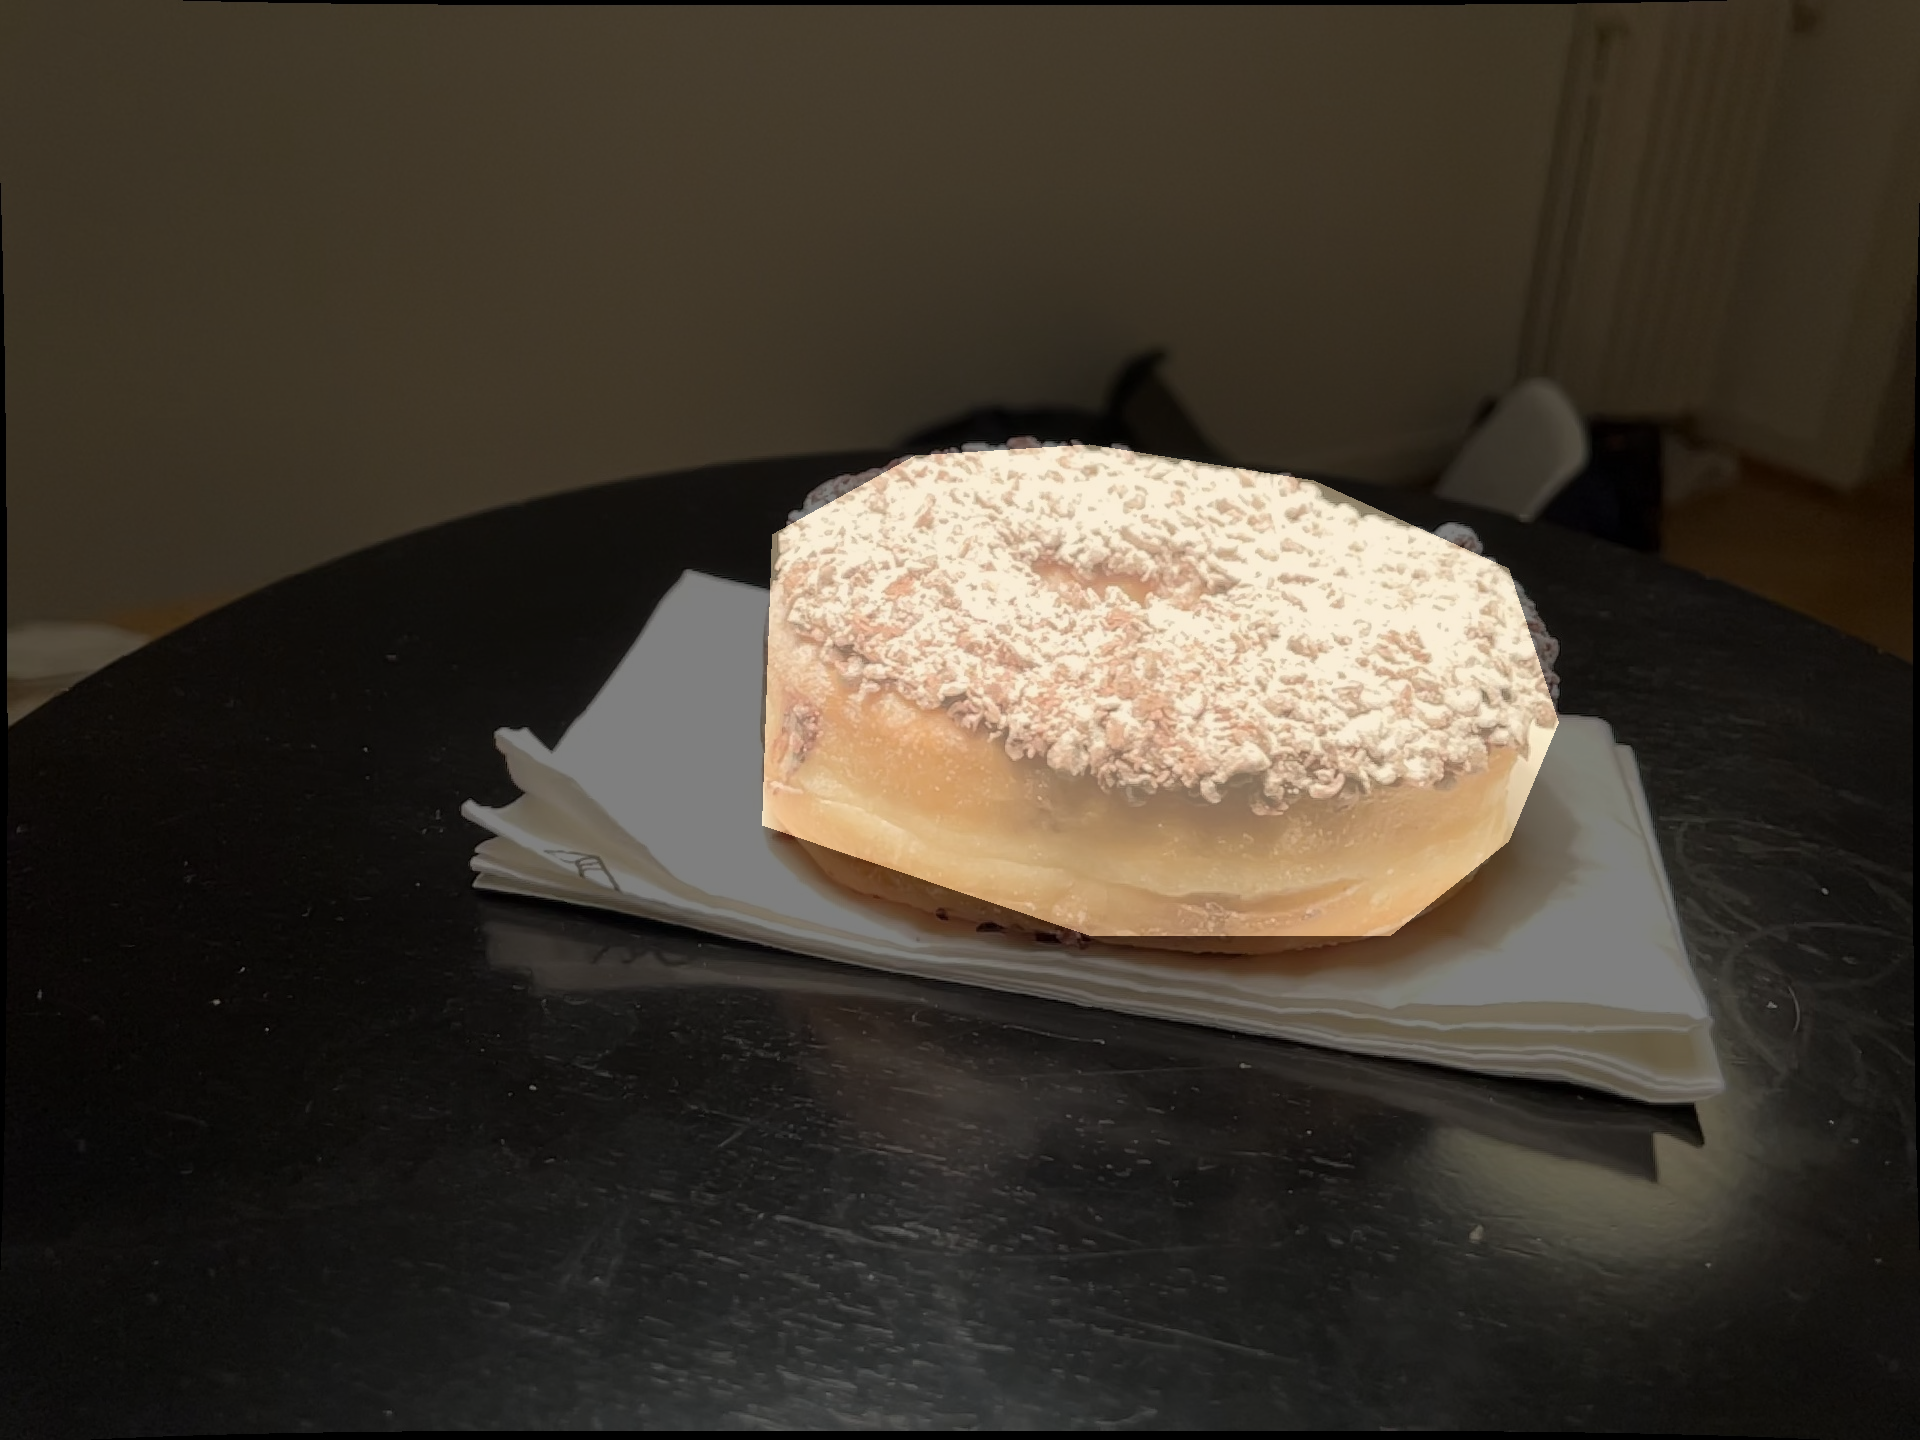

In [54]:
from pathlib import Path
from PIL import ImageDraw
from PIL import Image
import pprint
import json

mask_path = Path("/home/asl-student-mf/datasets/baking-davis/Annotations/480p/doughnut1/annotations.json")
out_path = Path("/home/asl-student-mf/datasets/baking-davis/Annotations/480p/doughnut1/00000.png")
img_path = Path("/home/asl-student-mf/datasets/baking-davis/JPEGImages/480p/doughnut1/00000.jpg")
assert mask_path.exists() and img_path.exists()
colors = {
    "foreground": "wheat"
}

# load the base image (for visual verification of the results only)
base_img = Image.open(img_path)


masks = json.load(open(mask_path))
mask_img = None

# parse the json dict and convert the polygon mask to an image mask
for mask in masks:
    for annotation in mask["annotations"]:
        for result in annotation["result"]:
            w = result["original_width"]
            h = result["original_height"]
            if not mask_img:
                mask_img = Image.new("RGB", (w, h))
            polygon = result["value"]["points"]
            # polygon labels are in % of the original image size
            label = result["value"]["polygonlabels"][0]
            x = list(map(lambda p: int(w * p[0] / 100), polygon))
            y = list(map(lambda p: int(h * p[1] / 100), polygon))

            # draw the polygon
            draw = ImageDraw.Draw(mask_img)
            draw.polygon(list(zip(x, y)), fill=colors[label])
            
# show the image (for visualization only)
Image.blend(base_img, mask_img, 0.5)

# save the genreated mask
mask_img.save(out_path)

## Convert tracked masks to the autolabel format

In [25]:
from pathlib import Path
from PIL import Image
import numpy as np

CLASSES = {
    "null": 0,
    "background": 1,
    "foreground": 2
}
SEM_SIZE = (720, 540)
img_dir = Path("/home/asl-student-mf/projects/src/github.com/visionml/pytracking/pytracking/segmentation_results/rts/rts50")
out_dir = Path("/home/asl-student-mf/datasets/baking-in-the-feature/scenes/doughnut_tracked/semantic")
assert img_dir.exists() and out_dir.exists()

for img_path in sorted(img_dir.glob("*.png")):
    if not img_path.is_file():
        continue
        
    img = np.array(Image.open(img_path).resize(SEM_SIZE))
    foreground = img > 0
    background = ~foreground
    null = img < 0
    # remap classes to the autolabel format
    img[foreground] = CLASSES["foreground"]
    img[background] = CLASSES["background"]
    img[null] = CLASSES["null"]
    # save image to out_dir
    Image.fromarray(img).save(out_dir / img_path.name)